In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

from autorank import plot_stats, autorank, create_report

In [9]:
df_classif = pd.read_csv("classif.csv")
df_restrict_classif_pred =pd.read_csv("restricted_classif_pred.csv")
df_restrict_classif_true = pd.read_csv("restricted_classif_true.csv")
df_expl = pd.read_csv("expl_metrics.csv")

df_classif["target"]=df_classif["target"].apply(str)
df_expl["target"]=df_expl["target"].apply(str)

df_expl = df_classif.merge(df_expl,on=["config_name","dataset_name","filename","target","model","explanation"],suffixes=["_orig","_true"])

df_pred = df_classif.merge(df_restrict_classif_pred,
                           on=["config_name","dataset_name","filename","target","model","explanation"],
                           suffixes=["_orig","_pred"])
predcol = ['config_name', 'dataset_name', 'filename', 'target',
       'model','explanation', 'roc_auc_score_orig',
       'roc_auc_score_pred','topKnonlagged',"topKlagged","lagged"]
df_pred = df_pred[[x for x in predcol if x in df_pred.columns]]



df_true = df_classif.merge(df_restrict_classif_true,
                           on=["config_name","dataset_name","filename","target","model"],
                           suffixes=["_orig","_true"])
df_true = df_true[['config_name','dataset_name', 'filename', 'target', "explanation",
       'model', 'roc_auc_score_orig',
       'roc_auc_score_true', "lagged"]]


df_ref = pd.read_csv("reference.csv")

df_classif = df_classif.merge(df_ref,on=["dataset_name","filename","target"])
df_expl = df_expl.merge(df_ref,on=["dataset_name","filename","target"])
df_true = df_true.merge(df_ref,on=["dataset_name","filename","target"])
df_pred = df_pred.merge(df_ref,on=["dataset_name","filename","target"])

#assemble all lagged AUROC in a single dataframe
df_true_lagged = df_true[df_true["lagged"]==True]
df_pred_lagged = df_pred[df_pred["lagged"]==True]
df_true_pred = df_pred_lagged.merge(df_true_lagged[["roc_auc_score_true","dataset_name","filename","target","config_name","explanation","lagged"]],
                                    on=["dataset_name","filename","target","config_name","explanation","lagged"])

#replace names
df_expl = df_expl.replace(to_replace="SynthNonlin/7ts2h",value="7ts2h")
df_expl = df_expl.replace(to_replace="fMRI_processed_by_Nauta/returns/our_selection",value="fMRI")
df_expl = df_expl.replace(to_replace="TestCLIM_N-5_T-250/returns",value="CLIM")
df_expl = df_expl.replace(to_replace="FinanceCPT/returns/our_selection",value="FINANCE")

df_true_pred = df_true_pred.replace(to_replace="SynthNonlin/7ts2h",value="7ts2h")
df_true_pred = df_true_pred.replace(to_replace="fMRI_processed_by_Nauta/returns/our_selection",value="fMRI")
df_true_pred = df_true_pred.replace(to_replace="TestCLIM_N-5_T-250/returns",value="CLIM")
df_true_pred = df_true_pred.replace(to_replace="FinanceCPT/returns/our_selection",value="FINANCE")

df_expl = df_expl.replace(to_replace="OS",value="FO")
df_true_pred = df_true_pred.replace(to_replace="OS",value="FO")

df_true_pred = df_true_pred.replace(to_replace="XCM-2D",value="XCM")

#merge all
df_true_pred_expl = df_true_pred.merge(df_expl[['config_name', 'dataset_name', 'filename', 'target', 'model',
       'explanation', 'topKlagged',"precision@k_mean_nonlagged"]],on=['config_name', 'dataset_name', 'filename', 'target', 'model',
       'explanation', 'topKlagged'])

df_true_pred_expl["EOCOdiff"] = df_true_pred_expl["roc_auc_score_pred"]-df_true_pred_expl["roc_auc_score_true"]

<ipython-input-9-504db0957f54>:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_expl = pd.read_csv("expl_metrics.csv")


## Wilcoxon test

In [ ]:
#build the pandas dataframe for each pair of models (EO,CO)

df=df_true_pred[["dataset_name","filename","target","model","explanation","roc_auc_score_pred","roc_auc_score_true"]]
df = df.groupby(["model","explanation","dataset_name","filename","target"]).mean()

df1 = df["roc_auc_score_pred"]
df2 = df["roc_auc_score_true"]
df1 = df1.reset_index()
df2 = df2.reset_index()
df1 = df1.rename(columns={"roc_auc_score_pred":"roc_auc_score"})
df2 = df2.rename(columns={"roc_auc_score_true":"roc_auc_score"})
df1["type"]="_EO_"
df2["type"]="_CO_"
df1["treatment"]=df1["dataset_name"]+df1["model"]+df1["type"]+df1["explanation"]
df1["block"]=df1["filename"]+df1["target"]
df2["treatment"]=df2["dataset_name"]+df2["model"]+df2["type"]+df2["explanation"]
df2["block"]=df2["filename"]+df2["target"]
data_test = pd.concat((df1[["block","treatment","roc_auc_score"]],df2[["block","treatment","roc_auc_score"]]))

data_nonmelted = data_test.pivot(index = "treatment",columns="block")

In [ ]:
#is CO greater than EO ? Yes if pval <0.05

def p_value_fun(data,model,expl,alternative="two-sided"):
    pval= wilcoxon(x=data_nonmelted.T[data+model+"_CO_"+expl]["roc_auc_score"].values,
         y=data_nonmelted.T[data+model+"_EO_"+expl]["roc_auc_score"].values,
         nan_policy="omit",alternative=alternative)[1]
    return pval

print("""
& 7ts2h & CLIM & fMRI \\\\
dCAM+FA & {0:.2e} & {1:.2e} & {2:.2e} \\\\
dCAM+FP & {3:.2e} & {4:.2e} & {5:.2e} \\\\
dCAM+IG & {6:.2e} & {7:.2e} & {8:.2e} \\\\
dCAM+GS & {9:.2e} & {10:.2e} & {11:.2e} \\\\
dCAM+dCAM & {12:.2e} & {13:.2e} & {14:.2e}\\\\
LSTM+FA & {15:.2e} & {16:.2e} & {17:.2e} \\\\
LSTM+FP & {18:.2e} & {19:.2e} & {20:.2e} \\\\
LSTM+IG & {21:.2e} & {22:.2e} & {23:.2e} \\\\
LSTM+GS & {24:.2e} & {25:.2e} & {26:.2e}\\\\
XCM+FA & {27:.2e} & {28:.2e} & {29:.2e} \\\\
XCM+FP & {30:.2e} & {31:.2e} & {32:.2e} \\\\
XCM+IG & {33:.2e} & {34:.2e} & {35:.2e} \\\\
XCM+GS & {36:.2e} & {37:.2e} & {38:.2e} \\\\
XCM+XCM & {39:.2e} & {40:.2e} & {41:.2e} \\\\
Transformer+FA & {42:.2e} & {43:.2e} & {44:.2e} \\\\
Transformer+FP & {45:.2e} & {46:.2e} & {47:.2e} \\\\
Transformer+IG & {48:.2e} & {49:.2e} & {50:.2e} \\\\
Transformer+GS & {51:.2e} & {52:.2e} & {53:.2e}
""".format(*[p_value_fun(data,model,expl,alternative="greater") for data,model,expl in 
            [
                ("7ts2h","dCAM","FA"),("CLIM","dCAM","FA"),("fMRI","dCAM","FA"),
                ("7ts2h","dCAM","FP"),("CLIM","dCAM","FP"),("fMRI","dCAM","FP"),
                ("7ts2h","dCAM","IG"),("CLIM","dCAM","IG"),("fMRI","dCAM","IG"),
                ("7ts2h","dCAM","GS"),("CLIM","dCAM","GS"),("fMRI","dCAM","GS"),
                ("7ts2h","dCAM","dCAM"),("CLIM","dCAM","dCAM"),("fMRI","dCAM","dCAM"),
                ("7ts2h","LSTM","FA"),("CLIM","LSTM","FA"),("fMRI","LSTM","FA"),
                ("7ts2h","LSTM","FP"),("CLIM","LSTM","FP"),("fMRI","LSTM","FP"),
                ("7ts2h","LSTM","IG"),("CLIM","LSTM","IG"),("fMRI","LSTM","IG"),
                ("7ts2h","LSTM","GS"),("CLIM","LSTM","GS"),("fMRI","LSTM","GS"),
                ("7ts2h","XCM_pytorch","FA"),("CLIM","XCM_pytorch","FA"),("fMRI","XCM_pytorch","FA"),
                ("7ts2h","XCM_pytorch","FP"),("CLIM","XCM_pytorch","FP"),("fMRI","XCM_pytorch","FP"),
                ("7ts2h","XCM_pytorch","IG"),("CLIM","XCM_pytorch","IG"),("fMRI","XCM_pytorch","IG"),
                ("7ts2h","XCM_pytorch","GS"),("CLIM","XCM_pytorch","GS"),("fMRI","XCM_pytorch","GS"),
                ("7ts2h","XCM_pytorch","XCM"),("CLIM","XCM_pytorch","XCM"),("fMRI","XCM_pytorch","XCM"),
                ("7ts2h","transformer","FA"),("CLIM","transformer","FA"),("fMRI","transformer","FA"),
                ("7ts2h","transformer","FP"),("CLIM","transformer","FP"),("fMRI","transformer","FP"),
                ("7ts2h","transformer","IG"),("CLIM","transformer","IG"),("fMRI","transformer","IG"),
                ("7ts2h","transformer","GS"),("CLIM","transformer","GS"),("fMRI","transformer","GS"),
            ]])
)

In [ ]:
#build the pandas dataframe for each pair of models (EO,orig)

df=df_true_pred[["dataset_name","filename","target","model","explanation","roc_auc_score_pred","roc_auc_score_orig"]]
df = df.groupby(["model","explanation","dataset_name","filename","target"]).mean()

df1 = df["roc_auc_score_pred"]
df2 = df["roc_auc_score_orig"]
df1 = df1.reset_index()
df2 = df2.reset_index()
df1 = df1.rename(columns={"roc_auc_score_pred":"roc_auc_score"})
df2 = df2.rename(columns={"roc_auc_score_orig":"roc_auc_score"})
df1["type"]="_EO_"
df2["type"]="_orig_"
df1["treatment"]=df1["dataset_name"]+df1["model"]+df1["type"]+df1["explanation"]
df1["block"]=df1["filename"]+df1["target"]
df2["treatment"]=df2["dataset_name"]+df2["model"]+df2["type"]+df2["explanation"]
df2["block"]=df2["filename"]+df2["target"]
data_test = pd.concat((df1[["block","treatment","roc_auc_score"]],df2[["block","treatment","roc_auc_score"]]))

data_nonmelted = data_test.pivot(index = "treatment",columns="block")

In [ ]:
#is orig greater than EO ? Yes if pval <0.05

def p_value_fun(data,model,expl,alternative="two-sided"):
    pval= wilcoxon(x=data_nonmelted.T[data+model+"_orig_"+expl]["roc_auc_score"].values,
         y=data_nonmelted.T[data+model+"_EO_"+expl]["roc_auc_score"].values,
         nan_policy="omit",alternative=alternative)[1]
    return pval

print("""
& 7ts2h & CLIM & fMRI \\\\
dCAM+FA & {0:.2e} & {1:.2e} & {2:.2e} \\\\
dCAM+FP & {3:.2e} & {4:.2e} & {5:.2e} \\\\
dCAM+IG & {6:.2e} & {7:.2e} & {8:.2e} \\\\
dCAM+GS & {9:.2e} & {10:.2e} & {11:.2e} \\\\
dCAM+dCAM & {12:.2e} & {13:.2e} & {14:.2e}\\\\
LSTM+FA & {15:.2e} & {16:.2e} & {17:.2e} \\\\
LSTM+FP & {18:.2e} & {19:.2e} & {20:.2e} \\\\
LSTM+IG & {21:.2e} & {22:.2e} & {23:.2e} \\\\
LSTM+GS & {24:.2e} & {25:.2e} & {26:.2e}\\\\
XCM+FA & {27:.2e} & {28:.2e} & {29:.2e} \\\\
XCM+FP & {30:.2e} & {31:.2e} & {32:.2e} \\\\
XCM+IG & {33:.2e} & {34:.2e} & {35:.2e} \\\\
XCM+GS & {36:.2e} & {37:.2e} & {38:.2e} \\\\
XCM+XCM & {39:.2e} & {40:.2e} & {41:.2e} \\\\
Transformer+FA & {42:.2e} & {43:.2e} & {44:.2e} \\\\
Transformer+FP & {45:.2e} & {46:.2e} & {47:.2e} \\\\
Transformer+IG & {48:.2e} & {49:.2e} & {50:.2e} \\\\
Transformer+GS & {51:.2e} & {52:.2e} & {53:.2e}
""".format(*[p_value_fun(data,model,expl,alternative="greater") for data,model,expl in 
            [
                ("7ts2h","dCAM","FA"),("CLIM","dCAM","FA"),("fMRI","dCAM","FA"),
                ("7ts2h","dCAM","FP"),("CLIM","dCAM","FP"),("fMRI","dCAM","FP"),
                ("7ts2h","dCAM","IG"),("CLIM","dCAM","IG"),("fMRI","dCAM","IG"),
                ("7ts2h","dCAM","GS"),("CLIM","dCAM","GS"),("fMRI","dCAM","GS"),
                ("7ts2h","dCAM","dCAM"),("CLIM","dCAM","dCAM"),("fMRI","dCAM","dCAM"),
                ("7ts2h","LSTM","FA"),("CLIM","LSTM","FA"),("fMRI","LSTM","FA"),
                ("7ts2h","LSTM","FP"),("CLIM","LSTM","FP"),("fMRI","LSTM","FP"),
                ("7ts2h","LSTM","IG"),("CLIM","LSTM","IG"),("fMRI","LSTM","IG"),
                ("7ts2h","LSTM","GS"),("CLIM","LSTM","GS"),("fMRI","LSTM","GS"),
                ("7ts2h","XCM_pytorch","FA"),("CLIM","XCM_pytorch","FA"),("fMRI","XCM_pytorch","FA"),
                ("7ts2h","XCM_pytorch","FP"),("CLIM","XCM_pytorch","FP"),("fMRI","XCM_pytorch","FP"),
                ("7ts2h","XCM_pytorch","IG"),("CLIM","XCM_pytorch","IG"),("fMRI","XCM_pytorch","IG"),
                ("7ts2h","XCM_pytorch","GS"),("CLIM","XCM_pytorch","GS"),("fMRI","XCM_pytorch","GS"),
                ("7ts2h","XCM_pytorch","XCM"),("CLIM","XCM_pytorch","XCM"),("fMRI","XCM_pytorch","XCM"),
                ("7ts2h","transformer","FA"),("CLIM","transformer","FA"),("fMRI","transformer","FA"),
                ("7ts2h","transformer","FP"),("CLIM","transformer","FP"),("fMRI","transformer","FP"),
                ("7ts2h","transformer","IG"),("CLIM","transformer","IG"),("fMRI","transformer","IG"),
                ("7ts2h","transformer","GS"),("CLIM","transformer","GS"),("fMRI","transformer","GS"),
            ]])
)

In [ ]:
#build the pandas dataframe for each pair of models (CO,orig)

df=df_true_pred[["dataset_name","filename","target","model","explanation","roc_auc_score_true","roc_auc_score_orig"]]
df=df[df["explanation"]=="FA"]#same information repeated across xAI method
df = df.groupby(["model","dataset_name","filename","target"]).mean()

df1 = df["roc_auc_score_true"]
df2 = df["roc_auc_score_orig"]
df1 = df1.reset_index()
df2 = df2.reset_index()
df1 = df1.rename(columns={"roc_auc_score_true":"roc_auc_score"})
df2 = df2.rename(columns={"roc_auc_score_orig":"roc_auc_score"})
df1["type"]="_CO"
df2["type"]="_orig"
df1["treatment"]=df1["dataset_name"]+df1["model"]+df1["type"]
df1["block"]=df1["filename"]+df1["target"]
df2["treatment"]=df2["dataset_name"]+df2["model"]+df2["type"]
df2["block"]=df2["filename"]+df2["target"]
data_test = pd.concat((df1[["block","treatment","roc_auc_score"]],df2[["block","treatment","roc_auc_score"]]))

data_nonmelted = data_test.pivot(index = "treatment",columns="block")

In [ ]:
#is CO greater than orig ? Yes if pval <0.05

def p_value_fun(data,model,alternative="two-sided"):
    if data+model+"_CO" in data_nonmelted.T.columns:
        pval= wilcoxon(x=data_nonmelted.T[data+model+"_CO"]["roc_auc_score"].values,
             y=data_nonmelted.T[data+model+"_orig"]["roc_auc_score"].values,
             nan_policy="omit",alternative=alternative)[1]
    else:
        pval = np.nan
    return pval

print("""
& 7ts2h & CLIM & fMRI \\\\
dCAM & {0:.2e} & {1:.2e} & {2:.2e} \\\\
LSTM & {3:.2e} & {4:.2e} & {5:.2e} \\\\
XCM &  {6:.2e} & {7:.2e} & {8:.2e} \\\\
Transformer &  {9:.2e} & {10:.2e} & {11:.2e}
""".format(*[p_value_fun(data,model,alternative="greater") for data,model in 
            [
                ("7ts2h","dCAM"),("CLIM","dCAM"),("fMRI","dCAM"),
                ("7ts2h","LSTM"),("CLIM","LSTM"),("fMRI","LSTM"),
                ("7ts2h","XCM_pytorch"),("CLIM","XCM_pytorch"),("fMRI","XCM_pytorch"),
                ("7ts2h","transformer"),("CLIM","transformer"),("fMRI","transformer")
            ]])
)

# Friedman Nemenyi

In [10]:
#build the pandas dataframe for each pair of models (EO,CO)

df=df_true_pred[["dataset_name","filename","target","explanation","model","roc_auc_score_pred","roc_auc_score_true","roc_auc_score_orig"]]


#uncomment below and modify to compute tests on specific datasets and models
#df = df[df["model"]=="transformer"]
#df = df[df["dataset_name"]=="fMRI"]




df = df[df["explanation"]!="FO"]

df1 = df.groupby(["explanation","model","dataset_name","filename","target"]).mean()
df2 = df[df["explanation"]=="FA"].groupby(["explanation","model","dataset_name","filename","target"]).mean()

df1 = df1["roc_auc_score_pred"]
df3 = df2["roc_auc_score_orig"]
df2 = df2["roc_auc_score_true"]
df1 = df1.reset_index()
df2 = df2.reset_index()
df3 = df3.reset_index()
df1 = df1.rename(columns={"roc_auc_score_pred":"accuracy"})
df2 = df2.rename(columns={"roc_auc_score_true":"accuracy"})
df3 = df3.rename(columns={"roc_auc_score_orig":"accuracy"})

df2["explanation"]="CO"
df3["explanation"]="Full"

df1["classifier_name"]=df1["explanation"]
df1["dataset_name"]=df1["dataset_name"]+df1["filename"]+df1["target"]+df1["model"]
df2["classifier_name"]=df2["explanation"]
df2["dataset_name"]=df2["dataset_name"]+df2["filename"]+df2["target"]+df1["model"]
df3["classifier_name"]=df3["explanation"]
df3["dataset_name"]=df3["dataset_name"]+df3["filename"]+df3["target"]+df1["model"]

df_test = pd.concat((df1[["classifier_name","dataset_name","accuracy"]],
                     df2[["classifier_name","dataset_name","accuracy"]],
                     df3[["classifier_name","dataset_name","accuracy"]]))


Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


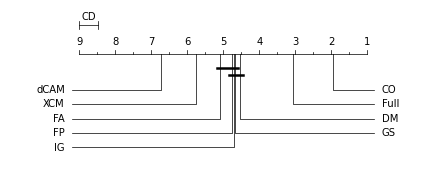

In [11]:
df_test=df_test.pivot(index="dataset_name",columns="classifier_name")["accuracy"]
plot_stats(autorank(df_test,force_mode="nonparametric"))
plt.savefig("cddiag.svg")

In [12]:
create_report(autorank(df_test,force_mode="nonparametric"))

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
The statistical analysis was conducted for 9 populations with 537 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations XCM (p=0.000), FA (p=0.000), FP (p=0.000), GS (p=0.000), DM (p=0.000), Full (p=0.000), and CO (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the d